<a href="https://colab.research.google.com/github/JimEverest/CAM/blob/main/1_CAM_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Get a pretrained model

In [1]:
import torch
import torchvision
import PIL
from PIL import Image
import matplotlib.pyplot as plt

In [ ]:
# !wget https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt

In [ ]:
import urllib.request  # the lib that handles the url stuff
target_url ="https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt"
classes = []
for line in urllib.request.urlopen(target_url):
  classes.append(line.decode('utf-8'))

In [164]:
resnet34 = torchvision.models.resnet34(pretrained=True)
# resnet18= torchvision.models.resnet18(pretrained=True)
# resnet50 = torchvision.models.resnet50(pretrained=True)
# resnet101 = torchvision.models.resnet101(pretrained=True)
# vgg = torchvision.models.vgg16(pretrained=True)
# model = torchvision.models.alexnet(pretrained=True)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [165]:
print(resnet34)
model = resnet34
# print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [181]:
imagenet_mean = torch.tensor([0.485, 0.456, 0.406])
imagenet_std = torch.tensor([0.229, 0.224, 0.225])

transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(imagenet_mean, imagenet_std),
])

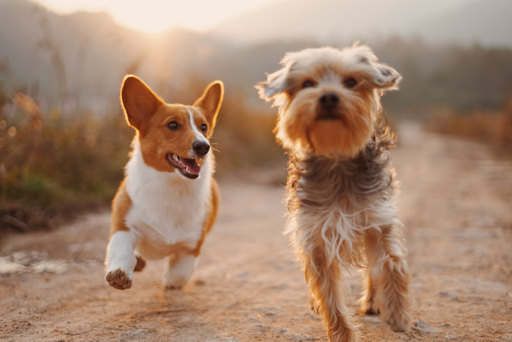

In [167]:
from torchvision import transforms
transform = transforms.Compose([
 transforms.Resize(256),
 transforms.CenterCrop(224),
 transforms.ToTensor(),
 transforms.Normalize(
 mean=[0.485, 0.456, 0.406],
 std=[0.229, 0.224, 0.225]
 )])
  
# img = Image.open("dog1.jpg")
img = Image.open("dog2.png")

img_t = transform(img)
batch_t = torch.unsqueeze(img_t, 0)
img

In [168]:
#model.forward
resnet34.eval()
out = resnet34(batch_t)
print(out.shape)
#print the top 5 classes predicted by the model
_, indices = torch.sort(out, descending=True)
percentage = torch.nn.functional.softmax(out, dim=1)[0] * 100
topk=5
[(classes[idx], idx.data, percentage[idx].item()) for idx in indices[0][:topk]]

torch.Size([1, 1000])


[('Yorkshire terrier\n', tensor(187), 51.229984283447266),
 ('Australian terrier\n', tensor(193), 16.027976989746094),
 ('Norfolk terrier\n', tensor(185), 8.283158302307129),
 ('Cardigan\n', tensor(264), 2.880218029022217),
 ('silky terrier\n', tensor(201), 2.0001211166381836)]

# Change the last layers of the model

In [182]:
# Paper approach:
# model.fc.weight.data[187].shape

def generate_attention_1(model, img_path, class_index, size=(224, 224)):

    ################################ remove last 2 layers
    newmodel = torch.nn.Sequential(*(list(model.children())[:-2]))
    ################################ Open and preprocess image
    image = PIL.Image.open(img_path)
    image.thumbnail(size, PIL.Image.ANTIALIAS)
    print("Image shape:", image.size)
    batch_t = transform(image)[None]
    ################################ extract weights from the last FC layer
    m_weights = model.fc.weight.data[class_index]
    print(m_weights.shape) #torch.Size([512])
    ################################ Forward
    fms = newmodel(batch_t)# [1, 512, 7, 7]
    fms = fms.squeeze(0)# [512,7,7]
    out_t = fms * m_weights[:, None, None]
    y_0 = torch.mean(out_t, dim=0) # AVG on channel dim. [512,7,7] --> [7,7]

    ################################ Viz
    plt.figure(figsize=(16, 8))
    ax = plt.subplot(1, 3, 1)
    ax.axis("off")
    plt.imshow(img)

    ax = plt.subplot(1, 3, 2)
    ax.axis("off")
    plt.imshow(y_0.detach().numpy())

    ax = plt.subplot(1, 3, 3)
    ax.axis("off")
    ax.imshow(img)
    ax.imshow(y_0.detach().numpy(), alpha=0.6, interpolation="bilinear", cmap="magma",
              extent=(0,img.size[0],img.size[1],0))

Image shape: (224, 150)
torch.Size([512])


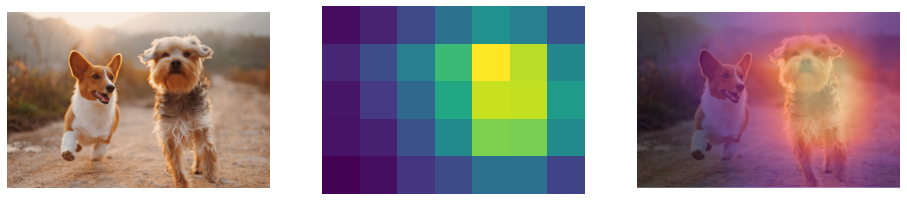

In [189]:
generate_attention_1(model, "dogs.jpg", 187, size=(224, 224))

Image shape: (512, 342)
torch.Size([512])


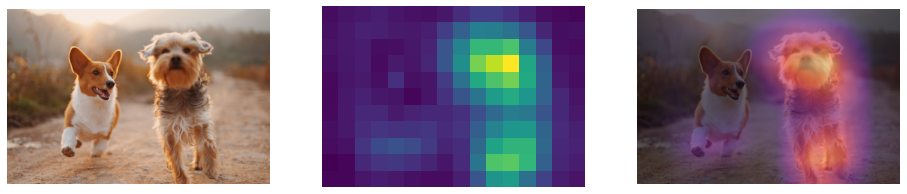

In [183]:
# See activation for "Yorkshire terrier" (Class index = 187)
generate_attention_1(model, "dogs.jpg", 187, size=(512, 512))


Image shape: (1024, 684)
torch.Size([512])


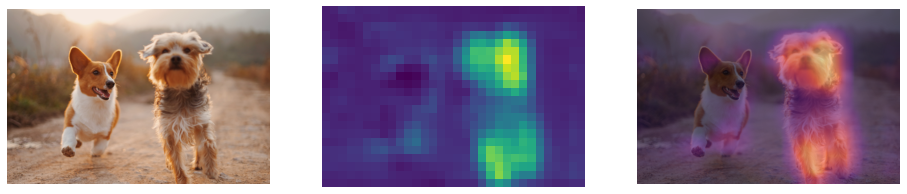

In [184]:
generate_attention_1(model, "dogs.jpg", 187, size=(1024, 1024))

Image shape: (512, 342)
torch.Size([512])


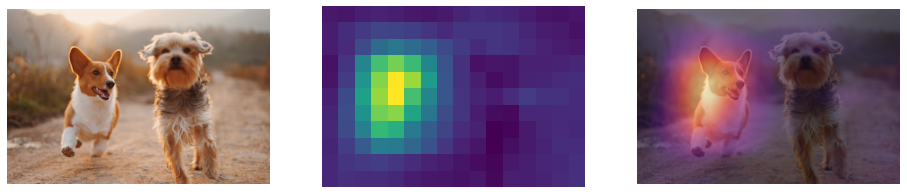

In [188]:
# See activation for "Corgi" (Class indexes = 263 & 264)
# 263: 'Pembroke, Pembroke Welsh corgi',
# 264: 'Cardigan, Cardigan Welsh corgi',

generate_attention_1(model, "dog2.png", 264, size=(512, 512))

In [141]:
def forward(self, x):
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)
    x = self.maxpool(x)

    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.layer4(x)
    
    # We remove those 3 layers...
    # x = self.avgpool(x)
    # x = torch.flatten(x, 1)
    # x = self.fc(x)

    # ... and we add this layer:
    x = self.conv_1x1(x)

    return x

model.forward = forward.__get__(model, torchvision.models.ResNet) # monkey-patching
model.conv_1x1 = torch.nn.Conv2d(512, 1000, kernel_size=1)
model.conv_1x1.weight.data = model.fc.weight.data[..., None, None]
model.conv_1x1.bias.data   = model.fc.bias.data

## Test model

Instead of output 1000-d vector, now the new model should output CAM tensor. 

In [143]:
print("224x224 --->", model.forward(torch.randn(1, 3, 224, 224)).shape )
print("512x512 --->", model.forward(torch.randn(1, 3, 512, 512)).shape )
# print("1024x1024 ->", model.forward(torch.randn(1, 3, 1024, 1024)).shape )
# print("2048x2048 ->", model.forward(torch.randn(1, 3, 2048, 2048)).shape )

224x224 ---> torch.Size([1, 1000, 7, 7])
512x512 ---> torch.Size([1, 1000, 16, 16])
1024x1024 -> torch.Size([1, 1000, 32, 32])
2048x2048 -> torch.Size([1, 1000, 64, 64])


In [108]:
# image = PIL.Image.open("dog1.png")
# image.thumbnail((512, 512), PIL.Image.ANTIALIAS)
# image = img

In [144]:
def generate_attention(path, class_indexes, size=(224, 224)):
    
    ################################ Open and preprocess image
    image = PIL.Image.open(path)
    image.thumbnail(size, PIL.Image.ANTIALIAS)
    
    print("Image shape:", image.size)
    tensor = transform(image)[None]
        
    ################################ Run image through model
    with torch.no_grad():
        logits = model(tensor)[0]
    probs = torch.softmax(logits, dim=0)
    attention_map = probs[class_indexes].sum(dim=0)

    plt.figure(figsize=(16, 8))
    ax = plt.subplot(1, 3, 1)
    ax.axis("off")
    plt.imshow(image)

    ax = plt.subplot(1, 3, 2)
    ax.axis("off")
    plt.imshow(attention_map)
    
    ax = plt.subplot(1, 3, 3)
    ax.axis("off")
    ax.imshow(image)
    ax.imshow(attention_map, alpha=0.6, interpolation="bilinear", cmap="magma",
              extent=(0,image.size[0],image.size[1],0))


## See activation for "Yorkshire terrier" (Class index = 187)

Image shape: (224, 150)


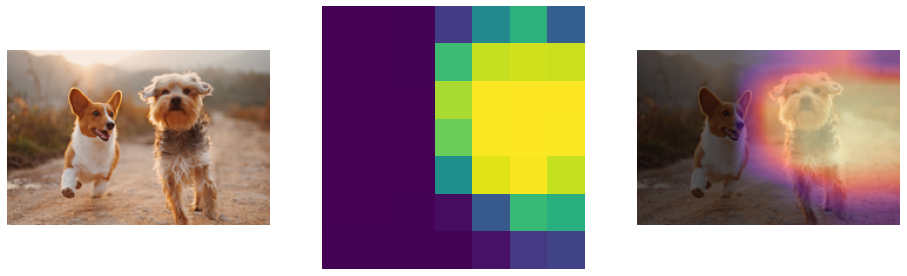

In [145]:
# generate_attention("dog1.jpg", class_indexes=[208])
generate_attention("dog2.png", class_indexes=[187])

## See activation for "Corgi" (Class indexes = 263 & 264)
- 263: 'Pembroke, Pembroke Welsh corgi',
- 264: 'Cardigan, Cardigan Welsh corgi',

Image shape: (224, 150)


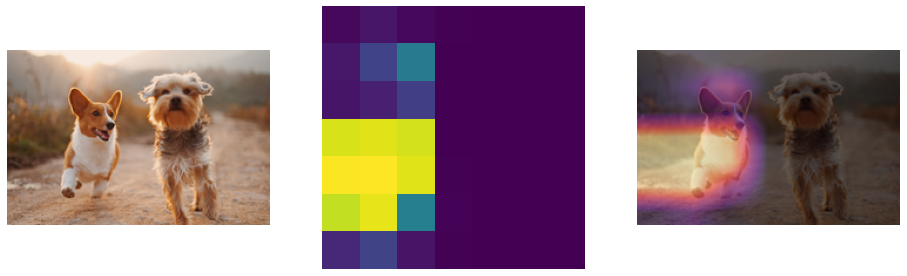

In [124]:
generate_attention("dog2.png", class_indexes=[263,264])

# Useful trick: Make image bigger

Image shape: (512, 342)


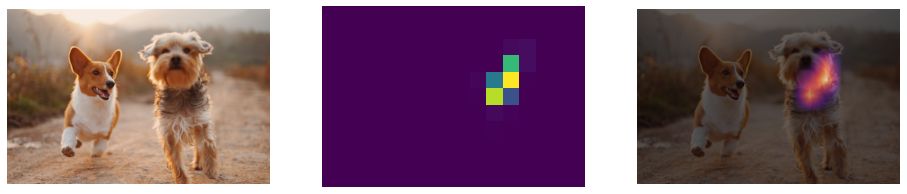

In [ ]:
generate_attention("img/dogs.jpg", class_indexes=[187], size=(512, 512))

Image shape: (512, 342)


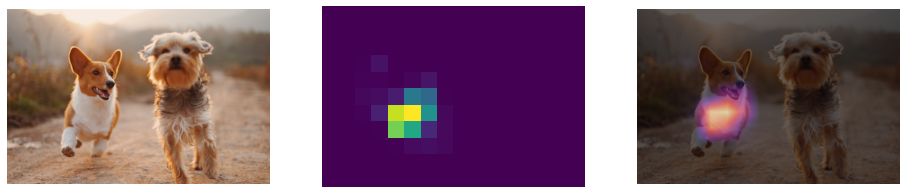

In [ ]:
generate_attention("img/dogs.jpg", class_indexes=[263,264], size=(512, 512))